# Project IT159: Self-Supervised Domain Adaptation for Skin Lesion Classification

**Notebook: Training & Development**

This notebook contains the complete research and development process for our project. It includes:
1.  Environment Setup and Data Loading.
2.  **Stage 1: Self-Supervised Pre-training (SimCLR)**.
3.  **Stage 2: Comparative Fine-tuning Experiments**:
    *   Experiment A: The main proposed method - **SSDA (SimCLR + DANN)**.
    *   Experiment B: An ablation study - **SSL-FT (SimCLR + Supervised FT)**.
    *   Experiment C: A strong baseline - **Supervised-only from ImageNet**.

In [ ]:
import os
import shutil
import pandas as pd

# ================================
# 1. KHAI BÁO ĐƯỜNG DẪN TRONG KAGGLE
# ================================
kaggle_root = "/kaggle/input/skin-cancer-mnist-ham10000"

csv_file = os.path.join(kaggle_root, "HAM10000_metadata.csv")
image_part1 = os.path.join(kaggle_root, "HAM10000_images_part_1")
image_part2 = os.path.join(kaggle_root, "HAM10000_images_part_2")

# Output folder (lưu lại trong Notebook)
output_root = "/kaggle/working/HAM10000_converted"
os.makedirs(output_root, exist_ok=True)

print("CSV tồn tại:", os.path.exists(csv_file))
print("Part1 tồn tại:", os.path.exists(image_part1))
print("Part2 tồn tại:", os.path.exists(image_part2))

# ================================
# 2. ĐỌC FILE METADATA
# ================================
df = pd.read_csv(csv_file)

# ================================
# 3. GỘP ẢNH VÀ CHUYỂN THÀNH FOLDER-PER-CLASS
# ================================
count = 0

for _, row in df.iterrows():
    img_name = row["image_id"] + ".jpg"
    label = str(row["dx"])

    # Tạo thư mục class tại working
    target_dir = os.path.join(output_root, label)
    os.makedirs(target_dir, exist_ok=True)

    # Đường dẫn ảnh ở part1 và part2
    img1 = os.path.join(image_part1, img_name)
    img2 = os.path.join(image_part2, img_name)

    # Copy ảnh sang thư mục mới
    if os.path.exists(img1):
        shutil.copy(img1, os.path.join(target_dir, img_name))
        count += 1

    elif os.path.exists(img2):
        shutil.copy(img2, os.path.join(target_dir, img_name))
        count += 1

    else:
        print("Không tìm thấy ảnh:", img_name)

print("DONE! Tổng số ảnh copy:", count)
print("Ảnh đã được lưu theo folder-per-class tại:")
print(output_root)


## 1. Data Loading and Preprocessing

In this section, we define the necessary data augmentations and create PyTorch DataLoaders. The dataset is split into three main parts for our experiments:

- **`simclr_loader`**: Utilizes all 10,015 unlabeled images from the HAM10000 dataset for the self-supervised pre-training stage. It uses a `TwoCropTransform` to generate pairs of augmented views for contrastive learning.
- **`src_loader`**: Contains the labeled source domain, a subset of HAM10000, used for supervised fine-tuning and training the classifier.
- **`tgt_loader`**: Represents the target domain, used for evaluation. In the DANN experiment, the unlabeled images from this loader are also used to align the domain distributions.

In [ ]:
import os
import glob
import random
import shutil

random.seed(42)

# ================================
# ĐƯỜNG DẪN TRONG KAGGLE
# ================================
drive_base = "/kaggle/working/HAM10000_converted"   # folder-per-class bạn vừa tạo

src_root = "/kaggle/working/HAM10000_split/source"
tgt_root = "/kaggle/working/HAM10000_split/target"

os.makedirs(src_root, exist_ok=True)
os.makedirs(tgt_root, exist_ok=True)

# Lấy danh sách class
classes = os.listdir(drive_base)
classes = [c for c in classes if os.path.isdir(os.path.join(drive_base, c))]

print("Classes:", classes)

# ================================
# SPLIT 60% SOURCE – 40% TARGET
# ================================
for c in classes:
    class_dir = os.path.join(drive_base, c)
    imgs = glob.glob(os.path.join(class_dir, "*.jpg"))

    if len(imgs) == 0:
        print("Class rỗng:", c)
        continue

    random.shuffle(imgs)
    k = int(len(imgs) * 0.6)

    src_imgs = imgs[:k]
    tgt_imgs = imgs[k:]

    # Tạo thư mục cho class
    os.makedirs(os.path.join(src_root, c), exist_ok=True)
    os.makedirs(os.path.join(tgt_root, c), exist_ok=True)

    # Copy ảnh
    for p in src_imgs:
        shutil.copy(p, os.path.join(src_root, c, os.path.basename(p)))

    for p in tgt_imgs:
        shutil.copy(p, os.path.join(tgt_root, c, os.path.basename(p)))

# ================================
# THỐNG KÊ
# ================================
src_count = sum(len(os.listdir(os.path.join(src_root, c))) for c in os.listdir(src_root))
tgt_count = sum(len(os.listdir(os.path.join(tgt_root, c))) for c in os.listdir(tgt_root))

print("DONE!")
print("Source size:", src_count)
print("Target size:", tgt_count)
print("Output folder:", "/kaggle/working/HAM10000_split")

In [ ]:
import shutil
print("Zipping the definitive data split...")
shutil.make_archive('golden_data_split', 'zip', '/kaggle/working/HAM10000_split')
print("Done. You can now download 'golden_data_split.zip' from the output.")

### Just run this cell if using the dataset "it159-final-checkpoints"


In [1]:
# ===================================================================
# CELL: DATA LOADING FROM PRE-BUILT "GOLDEN SPLIT"
# ===================================================================
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

# --- 1. PATH DEFINITIONS ---
# Path to the dataset containing our pre-built data splits and checkpoints
GOLDEN_DATASET_ROOT = "/kaggle/input/it159-final-checkpoints" 

# Define the final, consistent paths for the DataLoaders
# These paths point directly to the pre-split data within the input dataset.
src_root = os.path.join(GOLDEN_DATASET_ROOT, "golden_data_split/source")
tgt_root = os.path.join(GOLDEN_DATASET_ROOT, "golden_data_split/target")

# The 'simclr_root' still needs all 10k images. We will need to create this.
# Note: For the SimCLR pre-training stage, we still need to build the full
# 'folder-per-class' structure from the raw HAM10000 data. The pre-split
# data is only for the fine-tuning stage.
simclr_root_working = "/kaggle/working/HAM10000_converted"
if not os.path.exists(simclr_root_working):
    print("Creating full 'converted' directory for SimCLR pre-training...")
    # (This part is a simplified version of your original data prep)
    import pandas as pd
    import shutil
    from tqdm.notebook import tqdm
    
    KAGGLE_ROOT = "/kaggle/input/skin-cancer-mnist-ham10000"
    os.makedirs(simclr_root_working, exist_ok=True)
    csv_file = os.path.join(KAGGLE_ROOT, "HAM10000_metadata.csv")
    image_part1 = os.path.join(KAGGLE_ROOT, "HAM10000_images_part_1")
    image_part2 = os.path.join(KAGGLE_ROOT, "HAM10000_images_part_2")
    df = pd.read_csv(csv_file)
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Converting images for SimCLR"):
        img_name = row["image_id"] + ".jpg"
        label = str(row["dx"])
        target_dir = os.path.join(simclr_root_working, label)
        os.makedirs(target_dir, exist_ok=True)
        img1 = os.path.join(image_part1, img_name)
        img2 = os.path.join(image_part2, img_name)
        if os.path.exists(img1): shutil.copy(img1, os.path.join(target_dir, img_name))
        elif os.path.exists(img2): shutil.copy(img2, os.path.join(target_dir, img_name))
else:
    print("Full 'converted' directory for SimCLR already exists.")


# --- 2. DATALOADER CREATION ---
print("\n--- Creating DataLoaders from Golden Split ---")

# SimCLR augmentations
size = 224  # Nếu GPU yếu hoặc bị OOM, bạn có thể giảm xuống 128 lúc pre-train

def simclr_transform(size=size):
    # Giảm hue xuống 0.05 để tránh biến màu da thành màu lạ
    # Các thông số khác giữ 0.4 là ổn định
    color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05)
    
    return transforms.Compose([
        # Scale 0.5-1.0: Đảm bảo luôn lấy được phần lớn vùng bệnh
        transforms.RandomResizedCrop(size=size, scale=(0.5, 1.0)),
        
        # --- BỔ SUNG QUAN TRỌNG CHO ẢNH Y TẾ ---
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),   # Bệnh da liễu không phân biệt trên dưới
        transforms.RandomRotation(degrees=45),  # Xoay ảnh giúp model học tốt hơn
        # ---------------------------------------

        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        
        # GaussianBlur giúp model tập trung vào cấu trúc thay vì nhiễu hạt
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

class TwoCropTransform:
    """Create two crops for contrastive learning"""
    def __init__(self, base_transform):
        self.base = base_transform
        
    def __call__(self, x):
        q = self.base(x)
        k = self.base(x)
        return q, k

batch_simclr = 32
batch_ft = 32

# SimCLR loader still uses the full dataset prepared in /kaggle/working
simclr_train_dataset = ImageFolder(root=simclr_root_working, transform=TwoCropTransform(simclr_transform(size)))
simclr_loader = DataLoader(simclr_train_dataset, batch_size=batch_simclr, shuffle=True, num_workers=2, drop_last=True)

# FT/DANN loaders now use the direct paths from the input dataset
eval_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
src_dataset = ImageFolder(root=src_root, transform=eval_transform)
tgt_dataset = ImageFolder(root=tgt_root, transform=eval_transform)
src_loader = DataLoader(src_dataset, batch_size=batch_ft, shuffle=True, num_workers=2)
tgt_loader = DataLoader(tgt_dataset, batch_size=batch_ft, shuffle=False, num_workers=2)

# --- 3. FINAL INFORMATION ---
print(f"\nSimCLR dataset samples: {len(simclr_train_dataset)}")
print(f"Source labeled samples: {len(src_dataset)}")
print(f"Target samples: {len(tgt_dataset)}")

Creating full 'converted' directory for SimCLR pre-training...


Converting images for SimCLR:   0%|          | 0/10015 [00:00<?, ?it/s]


--- Creating DataLoaders from Golden Split ---

SimCLR dataset samples: 10015
Source labeled samples: 6007
Target samples: 4008


## 2. Stage 1: Self-Supervised Pre-training (SimCLR)

This stage is the foundation of our advanced methods (SSDA and SSL-FT). We take a standard ResNet-50 model, pre-trained on ImageNet, and further fine-tune it using the SimCLR framework on our entire unlabeled HAM10000 dataset.

**Objective:** To adapt the general visual features learned from ImageNet into domain-specific representations that are highly relevant to skin lesion characteristics.

The key components are:
- **Encoder `f(·)`:** A ResNet-50 backbone that extracts feature vectors from input images.
- **Projection Head `g(·)`:** A small MLP that maps the feature vectors into a latent space where contrastive loss is calculated.
- **NT-Xent Loss:** The contrastive loss function that pulls augmented views of the same image ("positive pairs") together while pushing apart all other images ("negative pairs").

In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import os

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
# SimCLR augmentations
size = 224  # Nếu GPU yếu hoặc bị OOM, bạn có thể giảm xuống 128 lúc pre-train

def simclr_transform(size=size):
    # Giảm hue xuống 0.05 để tránh biến màu da thành màu lạ
    # Các thông số khác giữ 0.4 là ổn định
    color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05)
    
    return transforms.Compose([
        # Scale 0.5-1.0: Đảm bảo luôn lấy được phần lớn vùng bệnh
        transforms.RandomResizedCrop(size=size, scale=(0.5, 1.0)),
        
        # --- BỔ SUNG QUAN TRỌNG CHO ẢNH Y TẾ ---
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),   # Bệnh da liễu không phân biệt trên dưới
        transforms.RandomRotation(degrees=45),  # Xoay ảnh giúp model học tốt hơn
        # ---------------------------------------

        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        
        # GaussianBlur giúp model tập trung vào cấu trúc thay vì nhiễu hạt
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

class TwoCropTransform:
    """Create two crops for contrastive learning"""
    def __init__(self, base_transform):
        self.base = base_transform
        
    def __call__(self, x):
        q = self.base(x)
        k = self.base(x)
        return q, k

print("Đã khởi tạo SimCLR Transform tối ưu cho HAM10000 với size =", size)

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# # ================================
# # ĐƯỜNG DẪN TRONG GOOGLE DRIVE
# # ================================
# simclr_root = "/kaggle/working/HAM10000_converted"
# src_root = "/kaggle/working/HAM10000_split/source"
# tgt_root = "/kaggle/working/HAM10000_split/target"

# ================================
# THAM SỐ
# ================================
batch_simclr = 32
batch_ft = 32


# ================================
# SIMCLR DATASET (unlabeled)
# ================================
simclr_train = ImageFolder(
    root=simclr_root,
    transform=TwoCropTransform(simclr_transform(size))
)

simclr_loader = DataLoader(
    simclr_train,
    batch_size=batch_simclr,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# ================================
# FINE-TUNE DATASET (source + target)
# ================================
eval_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

src_dataset = ImageFolder(root=src_root, transform=eval_transform)
tgt_dataset = ImageFolder(root=tgt_root, transform=eval_transform)

src_loader = DataLoader(src_dataset, batch_size=batch_ft, shuffle=False, num_workers=2)
tgt_loader = DataLoader(tgt_dataset, batch_size=batch_ft, shuffle=False, num_workers=2)

# ================================
# THÔNG TIN
# ================================
print("SimCLR dataset samples:", len(simclr_train))
print("Source labeled samples:", len(src_dataset))
print("Target samples:", len(tgt_dataset))
print("Classes:", src_dataset.classes)


### Run this cell for load backbone Resnet50 

In [3]:
# ==========================================
# CELL 1: BACKBONE RESNET50 & PROJECTION HEAD
# ==========================================

# 1. Load ResNet50 Pretrained
backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
feat_dim = backbone.fc.in_features  # ResNet50 = 2048 features

# 2. Tạo Encoder (bỏ lớp FC cuối)
modules = list(backbone.children())[:-1] 
encoder = nn.Sequential(*modules).to(DEVICE)

# 3. Projection Head (Cập nhật theo feat_dim mới)
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, proj_dim)
        )
    def forward(self, x):
        return self.net(x)

proj = ProjectionHead(feat_dim, proj_dim=128).to(DEVICE)

print(f"Encoder ResNet50 ready. Feature Dim: {feat_dim}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


Encoder ResNet50 ready. Feature Dim: 2048


In [ ]:
lr = 3e-4
opt = torch.optim.Adam(list(encoder.parameters()) + list(proj.parameters()), lr=lr)
print("Optimizer ready. lr=", lr)

In [ ]:
def nt_xent_loss(z_i, z_j, temp=0.8, eps=1e-8):
    z = torch.cat([z_i, z_j], dim=0)  # 2B x D
    z = F.normalize(z, dim=1)
    sim = torch.matmul(z, z.T)  # 2B x 2B
    batch_size = z_i.shape[0]
    mask = (~torch.eye(2*batch_size, dtype=torch.bool)).to(DEVICE)
    sim = sim / temp
    # clamp to avoid extreme values
    sim = torch.clamp(sim, min=-50.0, max=50.0)
    exp_sim = torch.exp(sim) * mask
    denom = exp_sim.sum(dim=1) + eps
    pos = torch.exp( (F.cosine_similarity(z_i, z_j, dim=-1)) / temp )
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log(pos / denom + eps)
    return loss.mean()

print("nt_xent_loss defined (temp=0.8 by default).")

In [ ]:
encoder.train(); proj.train()
batch = next(iter(simclr_loader))
(x1x2, _) = batch
x1, x2 = x1x2[0].to(DEVICE), x1x2[1].to(DEVICE)  # phù hợp với TwoCropTransform

with torch.set_grad_enabled(True):
    h1 = encoder(x1).squeeze()
    h2 = encoder(x2).squeeze()
    z1 = proj(h1)
    z2 = proj(h2)
    loss = nt_xent_loss(z1, z2, temp=0.8)
    print("Single-batch loss:", loss.item())
    assert not (torch.isnan(loss) or torch.isinf(loss)), "Loss is NaN or Inf — stop!"
print("Single-batch forward/backward check OK (loss finite).")

In [ ]:
# ==========================================
# CELL 2: SIMCLR TRAINING (TĂNG EPOCH)
# ==========================================
import os
from tqdm import tqdm

# Tăng epoch lên 50 để ResNet50 đủ thời gian học features
simclr_epochs = 50 
ckpt_dir = "/kaggle/working/HAM10000_outputs/simclr"
os.makedirs(ckpt_dir, exist_ok=True)

# Re-init optimizer cho SimCLR (chỉ train encoder & proj)
# Ở giai đoạn này chưa cần chỉnh LR kỹ, để mặc định 3e-4 hoặc 1e-4 đều ổn
opt = torch.optim.Adam(list(encoder.parameters()) + list(proj.parameters()), lr=3e-4)

losses = []

print(f"Bắt đầu train SimCLR trong {simclr_epochs} epochs...")

for epoch in range(simclr_epochs):
    encoder.train()
    proj.train()
    running = 0.0

    pbar = tqdm(simclr_loader,
                desc=f"SimCLR Epoch {epoch+1}/{simclr_epochs}",
                dynamic_ncols=True,
                leave=False)

    for (x1x2, _) in pbar:
        x1, x2 = x1x2[0].to(DEVICE), x1x2[1].to(DEVICE)

        # Forward
        h1 = encoder(x1).squeeze() # [B, 2048]
        h2 = encoder(x2).squeeze()
        z1 = proj(h1)
        z2 = proj(h2)

        loss = nt_xent_loss(z1, z2, temp=0.8)

        if torch.isnan(loss) or torch.isinf(loss):
            print("Loss bị NaN/Inf. Dừng lại.")
            break

        opt.zero_grad()
        loss.backward()
        opt.step()

        running += loss.item()
        pbar.set_postfix({"loss": running / (pbar.n + 1)})

    epoch_loss = running / len(simclr_loader)
    losses.append(epoch_loss)

    # Lưu checkpoint mỗi 10 epoch hoặc epoch cuối
    if (epoch + 1) % 10 == 0 or (epoch + 1) == simclr_epochs:
        torch.save(
            {"encoder": encoder.state_dict(),
             "proj": proj.state_dict(),
             "epoch": epoch+1},
            os.path.join(ckpt_dir, f"simclr_epoch_{epoch+1}.pth")
        )

print("SimCLR Pre-train hoàn tất!")
plt.plot(losses)
plt.title("SimCLR Loss")
plt.show()

## 3. Stage 2: Comparative Fine-tuning & Evaluation

After obtaining a powerful, domain-specific encoder from the SimCLR pre-training stage, we proceed to Stage 2. Here, we conduct a series of comparative experiments to determine the most effective strategy for the final classification task.

We will evaluate three distinct approaches:
- **A. SSDA (Our Proposed Method):** Combines the SimCLR encoder with DANN for explicit domain alignment.
- **B. SSL-FT (Ablation Study):** Uses the SimCLR encoder but with a simpler supervised fine-tuning, to isolate the effect of SSL.
- **C. Supervised Baseline:** A strong, standard approach using an ImageNet pre-trained encoder without any SimCLR fine-tuning.

**Note:** For a fair comparison, all fine-tuning experiments (A, B, and C) will use the same optimized training configuration, including the SGD optimizer, a StepLR scheduler, and weighted cross-entropy loss to handle class imbalance.

In [4]:
# ckpt = torch.load("/kaggle/working/HAM10000_outputs/simclr/simclr_epoch_50.pth", map_location=DEVICE)
ckpt = torch.load("/kaggle/input/it159-final-checkpoints/simclr_outputs/simclr_epoch_50(x1)(no_freeze).pth", map_location=DEVICE)
encoder.load_state_dict(ckpt["encoder"])
proj.load_state_dict(ckpt["proj"])
print("SIMCLR weights loaded!")


SIMCLR weights loaded!


### Experiment A: SSDA (Self-Supervised Domain Adaptation)

This is our main proposed framework. It leverages the SimCLR-pretrained encoder as a starting point. During fine-tuning, it is trained on the labeled source data for classification while simultaneously using the DANN architecture to align the feature distributions of the unlabeled target data.

- **Hypothesis:** By explicitly minimizing the domain shift, this method should achieve the best generalization performance on the target domain.

In [4]:
# =======================================================
# CELL 3: SETUP DANN (PHIÊN BẢN CUỐI CÙNG, ĐÃ SỬA LỖI)
# =======================================================
from collections import Counter
import numpy as np
import torch
import torch.nn as nn

# 1. Định nghĩa các Head
# class Classifier(nn.Module):
#     def __init__(self, feat_dim, num_classes):
#         super().__init__()
#         self.fc = nn.Linear(feat_dim, num_classes)
#     def forward(self, x): return self.fc(x)

class Classifier(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        # Thêm một lớp ẩn với ReLU và Dropout
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): 
        return self.net(x)

class DomainDiscriminator(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x): return self.net(x)

# Khởi tạo các Head
classes_list = src_dataset.classes # <-- Biến đúng là 'classes_list'
classifier = Classifier(feat_dim, len(classes_list)).to(DEVICE)
domain_disc = DomainDiscriminator(feat_dim).to(DEVICE)

# 2. Tính toán Class Weights (Phiên bản "mềm")
print("Đang tính toán class weights (phiên bản 'mềm' hơn)...")
all_labels = src_loader.dataset.targets
class_counts = Counter(all_labels)
class_counts = [class_counts[i] for i in sorted(class_counts)]

alpha = 0.3
weights = 1.0 / (torch.tensor(class_counts, dtype=torch.float) ** alpha)
# SỬA LỖI Ở ĐÂY: Dùng 'classes_list' thay vì 'classes'
class_weights = (weights / weights.sum() * len(classes_list)).to(DEVICE)
print(f"Class Weights đã được tinh chỉnh (alpha={alpha}): {class_weights}")

# 3. Định nghĩa Optimizer (SGD) và Scheduler
lr_enc = 1e-4
lr_cls = 1e-3

opt = torch.optim.SGD([
    {'params': encoder.parameters(), 'lr': lr_enc},
    {'params': classifier.parameters(), 'lr': lr_cls},
    {'params': domain_disc.parameters(), 'lr': lr_cls}
], momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

# 4. Định nghĩa các hàm Loss
criterion_cls = nn.CrossEntropyLoss(weight=class_weights)
criterion_dom = nn.CrossEntropyLoss()

print("DANN Setup Done. Using softened weights, SGD optimizer, and StepLR scheduler.")

Đang tính toán class weights (phiên bản 'mềm' hơn)...
Class Weights đã được tinh chỉnh (alpha=0.3): tensor([1.1081, 0.9676, 0.7701, 1.5156, 0.7674, 0.4476, 1.4237],
       device='cuda:0')
DANN Setup Done. Using softened weights, SGD optimizer, and StepLR scheduler.


In [5]:
from torch.autograd import Function

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd=1.0):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd=1.0):
    return GradReverse.apply(x, lambd)


Bắt đầu Fine-tune DANN trong 20 epochs...


DANN Epoch 20/20: 100%|██████████| 126/126 [00:45<00:00,  2.79it/s, L_cls=0.838, L_dom=0.630, Acc=0.763, λ=1.00]


DANN Training hoàn tất!


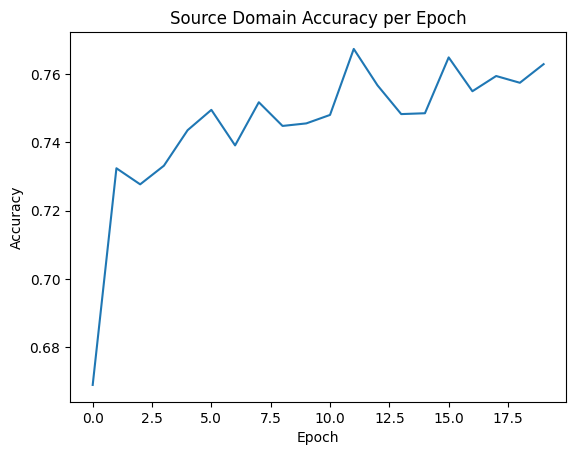

In [8]:
# ==========================================
# CELL 4: DANN TRAINING (DYNAMIC LAMBDA)
# ==========================================
dann_epochs = 20 # Tăng nhẹ epoch fine-tune nếu cần
os.makedirs("/kaggle/working/ssl_dann_outputs", exist_ok=True)

# Hàm Gradient Reverse Layer
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd=1.0):
        ctx.lambd = lambd
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd=1.0):
    return GradReverse.apply(x, lambd)

train_losses = []
domain_losses = []
accs = []

print(f"Bắt đầu Fine-tune DANN trong {dann_epochs} epochs...")

for epoch in range(dann_epochs):
    encoder.train()
    classifier.train()
    domain_disc.train()

    running_cls = 0.0
    running_dom = 0.0
    total = 0
    correct = 0
    
    # Lấy min length để zip không bị lỗi
    len_dataloader = min(len(src_loader), len(tgt_loader))
    
    # Dùng zip để lấy cặp dữ liệu Source - Target
    pbar = tqdm(enumerate(zip(src_loader, tgt_loader)),
                total=len_dataloader,
                desc=f"DANN Epoch {epoch+1}/{dann_epochs}")

    for batch_idx, ((xs, ys), (xt, _)) in pbar:
        xs, ys, xt = xs.to(DEVICE), ys.to(DEVICE), xt.to(DEVICE)

        # -------------------------------------------
        # 1. TÍNH DYNAMIC LAMBDA (Quan trọng)
        # -------------------------------------------
        # p chạy từ 0 đến 1 trong suốt quá trình training
        p = float(batch_idx + epoch * len_dataloader) / (dann_epochs * len_dataloader)
        # Lambda tăng dần theo hàm sigmoid: 0 -> 1
        lambda_grl = 2. / (1. + np.exp(-10 * p)) - 1
        
        # -------------------------------------------
        # 2. Forward Pass
        # -------------------------------------------
        # Feature extraction
        feat_s = encoder(xs).squeeze() # [B, 2048]
        feat_t = encoder(xt).squeeze()

        # Classification Loss (Chỉ trên Source)
        pred_s = classifier(feat_s)
        loss_cls = criterion_cls(pred_s, ys)

        # Domain Loss (Trên cả Source và Target)
        feat_all = torch.cat([feat_s, feat_t], dim=0)
        domain_labels = torch.cat([
            torch.zeros(feat_s.size(0)), # Source = 0
            torch.ones(feat_t.size(0))   # Target = 1
        ]).long().to(DEVICE)

        # Áp dụng Gradient Reversal với Dynamic Lambda
        feat_rev = grad_reverse(feat_all, lambd=lambda_grl)
        dom_pred = domain_disc(feat_rev)
        loss_dom = criterion_dom(dom_pred, domain_labels)

        # Tổng Loss
        loss = loss_cls + loss_dom

        # -------------------------------------------
        # 3. Backward & Update
        # -------------------------------------------
        opt.zero_grad()
        loss.backward()
        opt.step()

        # -------------------------------------------
        # 4. Metrics & Logging
        # -------------------------------------------
        running_cls += loss_cls.item()
        running_dom += loss_dom.item()

        preds = pred_s.argmax(dim=1)
        total += ys.size(0)
        correct += (preds == ys).sum().item()

        pbar.set_postfix({
            'L_cls': f"{running_cls/(batch_idx+1):.3f}",
            'L_dom': f"{running_dom/(batch_idx+1):.3f}",
            'Acc': f"{correct/total:.3f}",
            'λ': f"{lambda_grl:.2f}"  # In ra lambda để kiểm tra
        })

    scheduler.step()
    
    # Lưu metrics cuối epoch
    train_losses.append(running_cls/len_dataloader)
    accs.append(correct/total)
    
    
    # Lưu checkpoint
    torch.save({
        'encoder': encoder.state_dict(),
        'classifier': classifier.state_dict(),
        'domain_disc': domain_disc.state_dict(),
        'epoch': epoch
    }, f"/kaggle/working/ssl_dann_outputs/dann_epoch_{epoch+1}.pth")

print("DANN Training hoàn tất!")

# Vẽ biểu đồ Accuracy
plt.plot(accs)
plt.title("Source Domain Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [6]:
# ckpt = torch.load("/kaggle/working/ssl_dann_outputs/dann_epoch_20.pth", map_location=DEVICE)
ckpt = torch.load("/kaggle/input/it159-final-checkpoints/ssda_outputs/dann_epoch_20.pth", map_location=DEVICE)

encoder.load_state_dict(ckpt["encoder"])
classifier.load_state_dict(ckpt["classifier"])
domain_disc.load_state_dict(ckpt["domain_disc"])

print("DANN weights loaded!")

encoder.eval()
classifier.eval()
domain_disc.eval()


DANN weights loaded!


DomainDiscriminator(
  (net): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

Evaluating on Target Domain: 100%|██████████| 126/126 [00:30<00:00,  4.13it/s]



Target domain accuracy: 0.7567


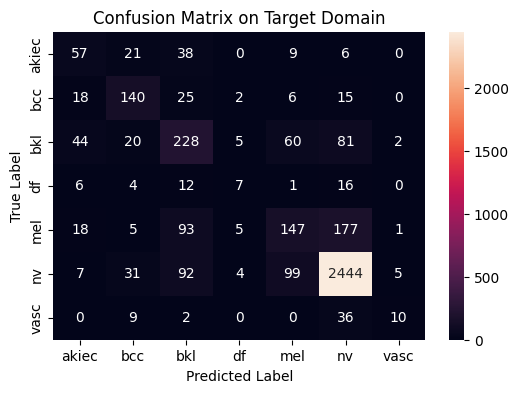


Generating t-SNE plot...


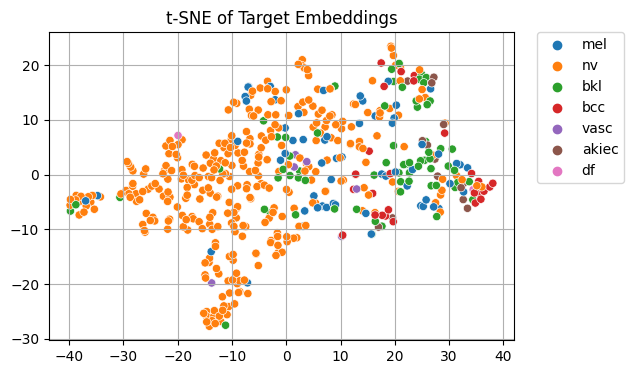

In [7]:
# =========================================================
# CELL ĐÁNH GIÁ (ĐÃ SỬA LỖI)
# =========================================================
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# Đặt model ở chế độ đánh giá
encoder.eval()
classifier.eval()

y_true = []
y_pred = []

# --- 1. Đánh giá Accuracy và vẽ Confusion Matrix ---
with torch.no_grad():
    # Dùng tgt_loader đã được định nghĩa ở trên
    for x, y in tqdm(tgt_loader, desc="Evaluating on Target Domain"):
        x = x.to(DEVICE)
        h = encoder(x).squeeze()
        logits = classifier(h)
        preds = torch.argmax(logits, dim=1)
        
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f"\nTarget domain accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)

# SỬA LỖI Ở ĐÂY: Dùng 'classes_list' thay vì 'classes'
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_list, yticklabels=classes_list, cmap='rocket')
plt.title("Confusion Matrix on Target Domain")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# --- 2. Vẽ t-SNE ---
print("\nGenerating t-SNE plot...")
# Lấy một batch lớn để vẽ cho đẹp
try:
    sample_loader = DataLoader(tgt_dataset, batch_size=512, shuffle=True)
    batch_x, batch_y = next(iter(sample_loader))
except StopIteration:
    print("Cannot get a batch for t-SNE, skipping.")
    batch_x, batch_y = None, None

if batch_x is not None:
    with torch.no_grad():
        emb = encoder(batch_x.to(DEVICE)).squeeze().cpu().numpy()
        
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    emb2 = tsne.fit_transform(emb)
    
    # SỬA LỖI Ở ĐÂY: Dùng 'classes_list' thay vì 'classes'
    hue_labels = [classes_list[i] for i in batch_y.numpy()]
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=emb2[:,0], y=emb2[:,1], hue=hue_labels, legend='full')
    plt.title("t-SNE of Target Embeddings")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()

### Experiment B: SSL-FT (SimCLR + Supervised Fine-tuning)

This experiment serves as an important "ablation study". We remove the Domain Adaptation (DA) component from our main framework to isolate and measure the contribution of the Self-Supervised Learning (SSL) stage alone. The SimCLR-pretrained encoder is fine-tuned directly on the labeled source data, just like the baseline.

- **Hypothesis:** This method will outperform the standard baseline, demonstrating the value of in-domain self-supervised pre-training. Comparing it to SSDA will reveal the actual impact of the DANN component.

In [6]:
# =============================================================================
# PHƯƠNG PHÁP TỐI ƯU (SIMCLR + SUPERVISED FINE-TUNING)
# =============================================================================
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print("Bắt đầu Phương pháp Tối ưu (size=224)...")

# --- 1. Load "Bộ não" SimCLR ---
# Khởi tạo kiến trúc ResNet50 rỗng
finetune_encoder = models.resnet50(weights=None) 
feat_dim_ft = finetune_encoder.fc.in_features
finetune_encoder.fc = nn.Identity()
modules = list(finetune_encoder.children())[:-1] 
finetune_encoder = nn.Sequential(*modules).to(DEVICE)

# Load checkpoint SimCLR bạn đã có
simclr_ckpt_path = "/kaggle/input/it159-final-checkpoints/simclr_outputs/simclr_epoch_50(x1)(no_freeze).pth" # <-- KIỂM TRA LẠI ĐƯỜNG DẪN NÀY!
if not os.path.exists(simclr_ckpt_path):
    raise FileNotFoundError(f"Không tìm thấy file checkpoint SimCLR tại: {simclr_ckpt_path}")
simclr_ckpt = torch.load(simclr_ckpt_path, map_location=DEVICE)
finetune_encoder.load_state_dict(simclr_ckpt['encoder'])
print("Encoder đã được load từ checkpoint SimCLR!")

classes_list = src_dataset.classes

# Khởi tạo Classifier mới
finetune_classifier = nn.Linear(feat_dim_ft, len(classes_list)).to(DEVICE)

# --- 2. Tính Class Weights ---
all_labels = src_loader.dataset.targets
class_weights_arr = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights_arr, dtype=torch.float).to(DEVICE)

# --- 3. Định nghĩa Optimizer, Scheduler, và Loss ---
finetune_epochs = 20
optimizer_ft = torch.optim.SGD(
    list(finetune_encoder.parameters()) + list(finetune_classifier.parameters()),
    lr=1e-3, momentum=0.9, weight_decay=5e-4
)
criterion_ft = nn.CrossEntropyLoss(weight=class_weights)
scheduler_ft = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

# --- 4. Huấn luyện ---
for epoch in range(finetune_epochs):
    finetune_encoder.train()
    finetune_classifier.train()
    pbar = tqdm(src_loader, desc=f"Fine-tune Epoch {epoch+1}/{finetune_epochs}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        features = finetune_encoder(images).squeeze()
        outputs = finetune_classifier(features)
        loss = criterion_ft(outputs, labels)
        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
    scheduler_ft.step()

# --- 5. Đánh giá ---
finetune_encoder.eval()
finetune_classifier.eval()
y_true_final, y_pred_final = [], []
with torch.no_grad():
    for images, labels in tqdm(tgt_loader, desc="Evaluating Final Model"):
        images = images.to(DEVICE)
        features = finetune_encoder(images).squeeze()
        outputs = finetune_classifier(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true_final.extend(labels.cpu().numpy())
        y_pred_final.extend(predicted.cpu().numpy())
final_accuracy = accuracy_score(y_true_final, y_pred_final)

# --- 6. In kết quả ---
print("\n" + "="*60)
print(f"KẾT QUẢ PHƯƠNG PHÁP TỐI ƯU (SimCLR + Supervised FT)")
print(f"   - Accuracy trên Target: {final_accuracy * 100:.2f}%")
print("="*60)
print("\nClassification Report (Final Model):\n")
print(classification_report(y_true_final, y_pred_final, target_names=classes_list, digits=4))

# --- 7. LƯU LẠI CHECKPOINT CUỐI CÙNG (Thêm vào cuối cell SSL-FT) ---
sslft_output_dir = '/kaggle/working/ssl_ft_final_outputs'
os.makedirs(sslft_output_dir, exist_ok=True)
torch.save(finetune_encoder.state_dict(), os.path.join(sslft_output_dir, 'ssl_ft_encoder_last.pth'))
torch.save(finetune_classifier.state_dict(), os.path.join(sslft_output_dir, 'ssl_ft_classifier_last.pth'))
print(f"Đã lưu checkpoint của SSL-FT vào thư mục: {sslft_output_dir}")

Bắt đầu Phương pháp Tối ưu (size=224)...
Encoder đã được load từ checkpoint SimCLR!


Evaluating Final Model: 100%|██████████| 126/126 [00:30<00:00,  4.14it/s]



KẾT QUẢ PHƯƠNG PHÁP TỐI ƯU (SimCLR + Supervised FT)
   - Accuracy trên Target: 70.73%

Classification Report (Final Model):

              precision    recall  f1-score   support

       akiec     0.4247    0.7099    0.5314       131
         bcc     0.5764    0.8058    0.6721       206
         bkl     0.5050    0.5750    0.5377       440
          df     0.3810    0.6957    0.4923        46
         mel     0.3673    0.6390    0.4664       446
          nv     0.9583    0.7289    0.8280      2682
        vasc     0.5100    0.8947    0.6497        57

    accuracy                         0.7073      4008
   macro avg     0.5318    0.7213    0.5968      4008
weighted avg     0.7927    0.7073    0.7318      4008

Đã lưu checkpoint của SSL-FT vào thư mục: /kaggle/working/ssl_ft_final_outputs


### Experiment C: Supervised Baseline (ImageNet Pre-trained)

This is our strong baseline for comparison. It represents the standard and most common approach in medical image analysis: taking a ResNet-50 model pre-trained on ImageNet and directly fine-tuning it on the labeled source data. It does not use SimCLR pre-training on HAM10000 or any domain adaptation techniques.

- **Hypothesis:** This robust baseline serves as the "golden standard" or the "score to beat". The performance of our proposed methods will be measured against this baseline.

In [4]:
# ===================================================================
# BASELINE TỐI ƯU (IMAGE-NET SUPERVISED)
# ===================================================================
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print("Bắt đầu chạy Baseline Tối ưu (size=224)...")
classes_list = src_dataset.classes

# --- 1. Khởi tạo mô hình (từ ImageNet) ---
baseline_encoder = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
feat_dim_bl = baseline_encoder.fc.in_features
baseline_encoder.fc = nn.Identity()
modules_bl = list(baseline_encoder.children())[:-1]
baseline_encoder = nn.Sequential(*modules_bl).to(DEVICE)
baseline_classifier = nn.Linear(feat_dim_bl, len(classes_list)).to(DEVICE)

# --- 2. Tính Class Weights ---
all_labels = src_loader.dataset.targets
class_weights_arr = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights_arr, dtype=torch.float).to(DEVICE)

# --- 3. Định nghĩa Optimizer, Scheduler, và Loss ---
baseline_epochs = 20
optimizer_bl = torch.optim.SGD(
    list(baseline_encoder.parameters()) + list(baseline_classifier.parameters()),
    lr=1e-3, momentum=0.9, weight_decay=5e-4
)
criterion_bl = nn.CrossEntropyLoss(weight=class_weights)
scheduler_bl = torch.optim.lr_scheduler.StepLR(optimizer_bl, step_size=10, gamma=0.1)

# --- 4. Huấn luyện ---
for epoch in range(baseline_epochs):
    baseline_encoder.train()
    baseline_classifier.train()
    pbar = tqdm(src_loader, desc=f"Baseline Epoch {epoch+1}/{baseline_epochs}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        features = baseline_encoder(images).squeeze()
        outputs = baseline_classifier(features)
        loss = criterion_bl(outputs, labels)
        optimizer_bl.zero_grad()
        loss.backward()
        optimizer_bl.step()
    scheduler_bl.step()

# --- 5. Đánh giá ---
baseline_encoder.eval()
baseline_classifier.eval()
y_true_bl, y_pred_bl = [], []
with torch.no_grad():
    for images, labels in tqdm(tgt_loader, desc="Evaluating Baseline"):
        images = images.to(DEVICE)
        features = baseline_encoder(images).squeeze()
        outputs = baseline_classifier(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true_bl.extend(labels.cpu().numpy())
        y_pred_bl.extend(predicted.cpu().numpy())
baseline_accuracy = accuracy_score(y_true_bl, y_pred_bl)

# --- 6. In kết quả ---
print("\n" + "="*50)
print(f"KẾT QUẢ BASELINE TỐI ƯU")
print(f"   - Accuracy trên Target: {baseline_accuracy * 100:.2f}%")
print("="*50)
print("\nClassification Report (Baseline):\n")
print(classification_report(y_true_bl, y_pred_bl, target_names=classes_list, digits=4))

# --- 7. LƯU LẠI CHECKPOINT CUỐI CÙNG (Thêm vào cuối cell Baseline) ---
baseline_output_dir = '/kaggle/working/baseline_final_outputs'
os.makedirs(baseline_output_dir, exist_ok=True)
torch.save(baseline_encoder.state_dict(), os.path.join(baseline_output_dir, 'baseline_encoder_last.pth'))
torch.save(baseline_classifier.state_dict(), os.path.join(baseline_output_dir, 'baseline_classifier_last.pth'))
print(f"Đã lưu checkpoint của Baseline vào thư mục: {baseline_output_dir}")

Bắt đầu chạy Baseline Tối ưu (size=224)...


Evaluating Baseline: 100%|██████████| 126/126 [00:29<00:00,  4.21it/s]



KẾT QUẢ BASELINE TỐI ƯU
   - Accuracy trên Target: 83.33%

Classification Report (Baseline):

              precision    recall  f1-score   support

       akiec     0.6320    0.6031    0.6172       131
         bcc     0.7354    0.7961    0.7646       206
         bkl     0.7095    0.6773    0.6930       440
          df     0.7222    0.5652    0.6341        46
         mel     0.5767    0.6323    0.6032       446
          nv     0.9180    0.9098    0.9139      2682
        vasc     0.8947    0.8947    0.8947        57

    accuracy                         0.8333      4008
   macro avg     0.7412    0.7255    0.7315      4008
weighted avg     0.8358    0.8333    0.8342      4008

Đã lưu checkpoint của Baseline vào thư mục: /kaggle/working/baseline_final_outputs
